## Simple Learning to Guess Prize Value

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class Task:
    def __init__(self):
        self.prize = np.random.randint(5, 10)

class Bidder:
    def __init__(self):
        self.bid = np.random.randint(0, 15)

class PurchaseEnv(gym.Env):
    def __init__(self, num_bidders=10):
        super(PurchaseEnv, self).__init__()
        self.task = Task()
        self.bidders = [Bidder() for _ in range(num_bidders)]
        self.action_space = spaces.Discrete(15)
        self.observation_space = spaces.Discrete(15)

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.bidders = [Bidder() for _ in range(len(self.bidders))]
        self.task = Task()
        initial_observation = np.array([self.task.prize])
        return initial_observation, {}
    
    def get_reward(self, action):
        bids = [bidder.bid for bidder in self.bidders] + [action]
        relevant_bids = [bid for bid in bids if bid <= self.task.prize]

        if relevant_bids:
            max_bid = max(relevant_bids)
            if action == max_bid:
                return self.task.prize
            elif action > self.task.prize:
                return -1
            else:
                return 0
        else:
            if action > self.task.prize:
                return -1
            else:
                return 0

    def step(self, action):
        reward = 0
        terminated = True
        truncated = False
        info = {}
        reward = self.get_reward(action)
        return np.array([self.task.prize]), reward, terminated, truncated, info

    def render(self, mode='human'):
        print(f"Task prize: {self.task.prize}")
        print(f"Bidders' bids: {[bidder.bid for bidder in self.bidders]}")

# Example usage
env = PurchaseEnv()
action = env.action_space.sample()
print("Sampled action:", action)

obs = env.reset()
# print("Initial observation:", obs)
obs, reward, done, truncated, info = env.step(action)
# print("Observation after step:", obs)
print("Reward:", reward)
# print("Done:", done)
# print("Info:", info)
env.render()

Sampled action: 0
Reward: 0
Task prize: 6
Bidders' bids: [9, 3, 14, 7, 8, 9, 2, 8, 14, 14]


In [30]:
from collections import defaultdict
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# Create the environment
# env = DummyVecEnv([lambda: PurchaseEnv()])
env = PurchaseEnv(num_bidders=30)

# Instantiate the agent
model = PPO("MlpPolicy", env, verbose=1, n_steps=2048, batch_size=64, n_epochs=10, learning_rate=3e-4)

# Train the agent
model.learn(total_timesteps=int(4e4))

# Test the trained agent
obs, _ = env.reset()
done = False
total_reward = 0

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward

print("Total reward after training with PPO:", total_reward)
env.render()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.17     |
| time/              |          |
|    fps             | 4531     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | 0.24       |
| time/                   |            |
|    fps                  | 3616       |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.02562379 |
|    clip_fraction        | 0.481      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.69

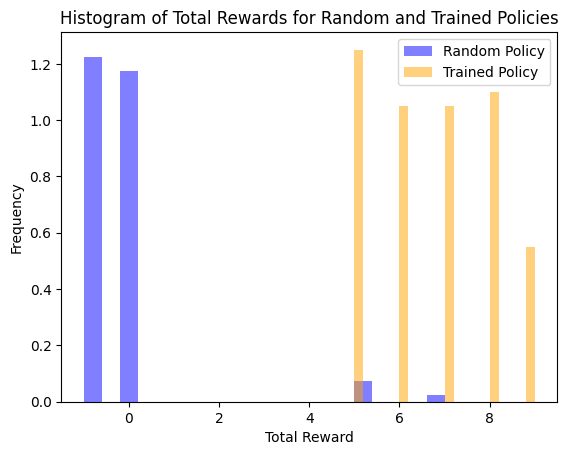

In [31]:
import matplotlib.pyplot as plt

# Update the environment with 20 bidders
env = PurchaseEnv(num_bidders=30)

# Run random policy
random_rewards = []
for _ in range(100):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
    random_rewards.append(total_reward)

# Run trained policy
ppo_rewards = []
for _ in range(100):
    obs, _= env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
    ppo_rewards.append(total_reward)

# Plot the results
plt.hist(random_rewards, bins=20, alpha=0.5, label='Random Policy', color='blue', density=True)
plt.hist(ppo_rewards, bins=20, alpha=0.5, label='Trained Policy', color='orange', density=True)
plt.legend(loc='upper right')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.title('Histogram of Total Rewards for Random and Trained Policies')
plt.show()

## Moving to dict observation spaces

In [38]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class PurchaseEnv(gym.Env):

    class Task:
        def __init__(self):
            self.prize = np.random.randint(5, 10)

    class Bidder:
        def __init__(self):
            self.bid = np.random.randint(0, 15)
            self.distance = np.random.randint(1, 4)

    def __init__(self, num_bidders=10):
        super(PurchaseEnv, self).__init__()
        self.task = self.Task()
        self.bidders = [self.Bidder() for _ in range(num_bidders)]
        self.distance = np.random.randint(1, 4)
        self.action_space = spaces.Discrete(15)
        self.observation_space = spaces.Dict({
            'prize': spaces.Discrete(15),
            'distance': spaces.Discrete(4)
        })

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.bidders = [self.Bidder() for _ in range(len(self.bidders))]
        self.task = self.Task()
        self.distance = np.random.randint(1, 4)
        initial_observation = {'prize': self.task.prize, 'distance': self.distance}
        return initial_observation, {}
    
    def get_reward(self, action):
        bids = [bidder.bid for bidder in self.bidders] + [action]
        relevant_bids = [
            bid for bid, bidder in zip(bids, self.bidders + [None])
            if bid <= (self.task.prize - (bidder.distance if bidder else self.distance))
        ]

        if relevant_bids:
            max_bid = max(relevant_bids)
            if action == max_bid:
                return self.task.prize - self.distance
            elif action > self.task.prize:
                return -1
            else:
                return 0
        else:
            return -1 if action > self.task.prize else 0

    def step(self, action):
        reward = 0
        terminated = True
        truncated = False
        info = {}
        reward = self.get_reward(action)
        return {'prize': self.task.prize, 'distance': self.distance}, reward, terminated, truncated, info

    def render(self, mode='human'):
        print(f"Task prize: {self.task.prize}")
        print(f"Bidders' bids: {[bidder.bid for bidder in self.bidders]}")
        print(f"Bidders' distances: {[bidder.distance for bidder in self.bidders]}")
        print(f"Distance: {self.distance}")

# Example usage
env = PurchaseEnv()
action = env.action_space.sample()
print("Sampled action:", action)

obs = env.reset()
# print("Initial observation:", obs)
obs, reward, done, truncated, info = env.step(action)
# print("Observation after step:", obs)
print("Reward:", reward)
# print("Done:", done)
# print("Info:", info)
env.render()

Sampled action: 7
Reward: -1
Task prize: 6
Bidders' bids: [10, 0, 0, 5, 5, 5, 5, 12, 6, 8]
Bidders' distances: [2, 2, 1, 2, 3, 2, 3, 2, 1, 3]
Distance: 2


In [2]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, CallbackList
from stable_baselines3.common.logger import configure
from envs.purchasing import PurchaseEnv
import os

# Create the environment
env = PurchaseEnv(num_bidders=10)

# Configure TensorBoard logging
log_dir = "./runs/baselines"
new_logger = configure(log_dir, ["stdout", "tensorboard"])

# Define a learning rate schedule
def linear_schedule(initial_value):
    def func(progress_remaining):
        return progress_remaining * initial_value
    return func

# Instantiate the agent with adaptive learning rate
model = PPO("MultiInputPolicy", env, verbose=0, n_steps=2048, batch_size=64, n_epochs=10, learning_rate=linear_schedule(3e-4), tensorboard_log=log_dir)
model.set_logger(new_logger)

# Create callbacks for saving models and evaluation
checkpoint_callback = CheckpointCallback(save_freq=int(1e4), save_path=f"{log_dir}/checkpoints", name_prefix='ppo_model')
eval_callback = EvalCallback(env, best_model_save_path=f"{log_dir}/best_model", log_path=log_dir, eval_freq=5000, deterministic=True, render=False)
callback = CallbackList([checkpoint_callback, eval_callback])

# Train the agent
model.learn(total_timesteps=int(1e5), callback=callback)

log_dir = "./runs/baselines"
model_path = os.path.join(log_dir, "best_model.zip")

# Save the model
model.save(model_path)

# Test the trained agent
obs, _ = env.reset()
done = False
total_reward = 0

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward

print("Total reward after training with PPO:", total_reward)
env.render()

Logging to ./runs/baselines
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.02     |
| time/              |          |
|    fps             | 4963     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | 0.77        |
| time/                   |             |
|    fps                  | 3401        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.026335169 |
|    clip_fraction        | 0.573       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.69       |
|    explained_variance   | -0.0258     |
| 

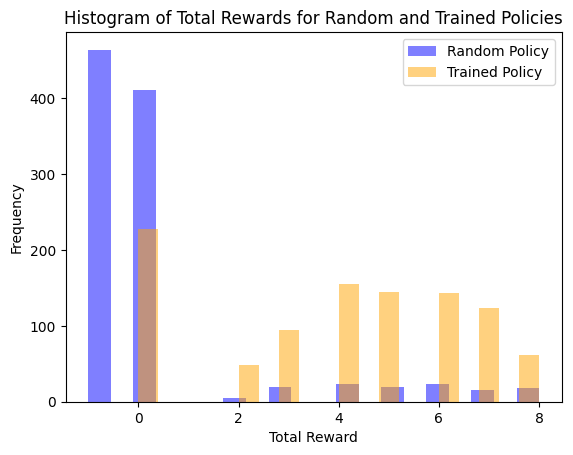

In [17]:
import matplotlib.pyplot as plt

# Update the environment with 20 bidders
env = PurchaseEnv(num_bidders=10)

# Run random policy
random_rewards = []
for _ in range(1000):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
    random_rewards.append(total_reward)

# Run trained policy
ppo_rewards = []
for _ in range(1000):
    obs, _= env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
    ppo_rewards.append(total_reward)

# Plot the results
plt.hist(random_rewards, bins=20, alpha=0.5, label='Random Policy', color='blue', density=False)
plt.hist(ppo_rewards, bins=20, alpha=0.5, label='Trained Policy', color='orange', density=False)
plt.legend(loc='upper right')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.title('Histogram of Total Rewards for Random and Trained Policies')
plt.show()

In [43]:
# Define a function to run the model and print the chosen action for different numbers of bidders
env = PurchaseEnv(num_bidders=10)
obs, _ = env.reset()
action, _states = model.predict(obs)

obs, reward, done, truncated, info = env.step(action)

env.render()

print(f'\nWith prize {obs["prize"]} and distance {obs["distance"]}, chose action {action}')

print(f"Got reward: {reward}")

Task prize: 6
Bidders' bids: [11, 10, 13, 8, 4, 6, 12, 10, 4, 12]
Bidders' distances: [2, 3, 1, 2, 3, 1, 1, 1, 1, 1]
Distance: 3

With prize 6 and distance 3, chose action 3
Got reward: 0


## Adding Task and Robot Classes

In [4]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class PurchaseEnv(gym.Env):

    class Task:
        def __init__(self):
            self.prize = np.random.randint(5, 10)
            self.type = np.random.randint(0, 2)

    class Bidder:
        def __init__(self):
            self.bid = np.random.randint(0, 15)
            self.distance = np.random.randint(1, 4)
            self.type = np.random.randint(0, 2)

    def __init__(self, num_bidders=10):
        super(PurchaseEnv, self).__init__()
        self.task = self.Task()
        self.bidders = [self.Bidder() for _ in range(num_bidders)]
        self.distance = np.random.randint(1, 4)
        self.type = np.random.randint(0, 2)
        self.action_space = spaces.Discrete(15)
        self.observation_space = spaces.Dict({
            'prize': spaces.Discrete(15),
            'distance': spaces.Discrete(4),
            'type': spaces.Discrete(2),
        })

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.bidders = [self.Bidder() for _ in range(len(self.bidders))]
        self.task = self.Task()
        self.distance = np.random.randint(1, 4)
        self.type = np.random.randint(0, 2)
        initial_observation = {'prize': self.task.prize, 'distance': self.distance, 'type': self.type}
        return initial_observation, {}
    
    def get_reward(self, action):

        type_match = self.type == self.task.type

        # filter out irrelevant bids
        relevant_bids = []

        for bid, bidder in zip([bidder.bid for bidder in self.bidders] + [action], self.bidders + [None]):
            if type_match:
                if bid <= (self.task.prize):
                    relevant_bids.append(bid)
            else:
                if bid <= (self.task.prize - (bidder.distance if bidder else self.distance)):
                    relevant_bids.append(bid)

        assert relevant_bids, "No relevant bids"
        
        # determine reward
        max_bid = max(relevant_bids)
        if action == max_bid:
            if type_match:
                return self.task.prize
            else:
                return self.task.prize - self.distance
        elif action > self.task.prize:
            return -1
        else:
            return 0

    def step(self, action):
        reward = 0
        terminated = True
        truncated = False
        info = {}
        reward = self.get_reward(action)
        return {'prize': self.task.prize, 'distance': self.distance}, reward, terminated, truncated, info

    def render(self, mode='human'):
        print(f"Task prize: {self.task.prize}")
        print(f"Bidders' bids: {[bidder.bid for bidder in self.bidders]}")
        print(f"Bidders' distances: {[bidder.distance for bidder in self.bidders]}")
        print(f"Distance: {self.distance}")

# Example usage
env = PurchaseEnv()
action = env.action_space.sample()
print("Sampled action:", action)

obs = env.reset()
# print("Initial observation:", obs)
obs, reward, done, truncated, info = env.step(action)
# print("Observation after step:", obs)
print("Reward:", reward)
# print("Done:", done)
# print("Info:", info)
env.render()

Sampled action: 8
Reward: -1
Task prize: 7
Bidders' bids: [9, 0, 1, 0, 4, 14, 0, 14, 12, 13]
Bidders' distances: [3, 1, 1, 2, 1, 2, 2, 2, 2, 3]
Distance: 3


In [5]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, CallbackList
from stable_baselines3.common.logger import configure
from envs.purchasing import PurchaseEnv
import os

# Create the environment
env = PurchaseEnv(num_bidders=10)

# Configure TensorBoard logging
log_dir = "./runs/baselines"
new_logger = configure(log_dir, ["stdout", "tensorboard"])

# Define a learning rate schedule
def linear_schedule(initial_value):
    def func(progress_remaining):
        return progress_remaining * initial_value
    return func

# Instantiate the agent with adaptive learning rate
model = PPO("MultiInputPolicy", env, verbose=0, n_steps=2048, batch_size=64, n_epochs=10, learning_rate=linear_schedule(3e-4), tensorboard_log=log_dir)
model.set_logger(new_logger)

# Create callbacks for saving models and evaluation
checkpoint_callback = CheckpointCallback(save_freq=int(1e4), save_path=f"{log_dir}/checkpoints", name_prefix='ppo_model')
eval_callback = EvalCallback(env, best_model_save_path=f"{log_dir}/best_model", log_path=log_dir, eval_freq=5000, deterministic=True, render=False)
callback = CallbackList([checkpoint_callback, eval_callback])

# Train the agent
model.learn(total_timesteps=int(1e5), callback=callback)

log_dir = "./runs/baselines"
model_path = os.path.join(log_dir, "best_model.zip")

# Save the model
model.save(model_path)

# Test the trained agent
obs, _ = env.reset()
done = False
total_reward = 0

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward

print("Total reward after training with PPO:", total_reward)
env.render()

Logging to ./runs/baselines
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.2      |
| time/              |          |
|    fps             | 5280     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | 0.23        |
| time/                   |             |
|    fps                  | 3717        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.026855508 |
|    clip_fraction        | 0.587       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.69       |
|    explained_variance   | -0.0174     |
| 

/Users/devg/robopt/.venv/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 1.08     |
| time/              |          |
|    fps             | 3077     |
|    iterations      | 3        |
|    time_elapsed    | 1        |
|    total_timesteps | 6144     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | 0.6         |
| time/                   |             |
|    fps                  | 3026        |
|    iterations           | 4           |
|    time_elapsed         | 2           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.027212795 |
|    clip_fraction        | 0.664       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.48       |
|    explained_variance   | 0.0519      |
|    lea

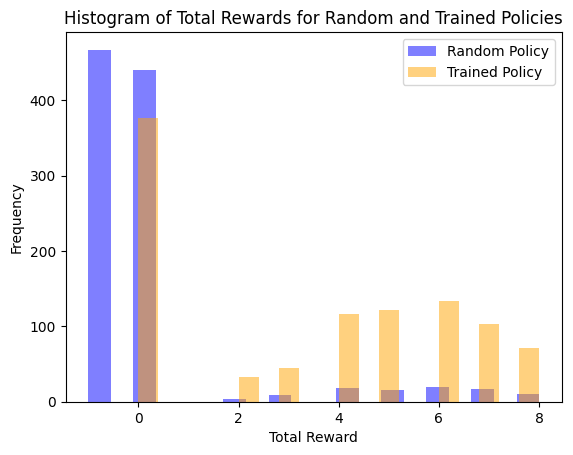

In [7]:
import matplotlib.pyplot as plt

# Update the environment with 20 bidders
env = PurchaseEnv(num_bidders=20)

# Run random policy
random_rewards = []
for _ in range(1000):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
    random_rewards.append(total_reward)

# Run trained policy
ppo_rewards = []
for _ in range(1000):
    obs, _= env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
    ppo_rewards.append(total_reward)

# Plot the results
plt.hist(random_rewards, bins=20, alpha=0.5, label='Random Policy', color='blue', density=False)
plt.hist(ppo_rewards, bins=20, alpha=0.5, label='Trained Policy', color='orange', density=False)
plt.legend(loc='upper right')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.title('Histogram of Total Rewards for Random and Trained Policies')
plt.show()